# GPU Info

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 20 15:49:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# Dependencies

In [3]:
!pip install 'ray[rllib]==1.11.0' torch

     |████████████████████████████████| 52.7 MB 146 kB/s 
     |████████████████████████████████| 4.1 MB 39.3 MB/s 
     |████████████████████████████████| 226 kB 75.4 MB/s 
     |████████████████████████████████| 1.2 MB 51.7 MB/s 
     |████████████████████████████████| 125 kB 63.4 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [1]:
!pip install gym\[atari,accept-rom-license\]==0.21.0

     |████████████████████████████████| 1.5 MB 7.2 MB/s 
     |████████████████████████████████| 1.6 MB 35.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616824 sha256=92c3489375da28db9b026108e33d0ee74b76497f9226a2a322195044db00c672
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=0d9ae9a4b80fcabf4e512aae01f8ce9dd8751290bd4e3f8ae77008154997673e
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built gym AutoROM.accept-rom-license
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


# Imports

In [4]:
import ray
import gym
import random
import numpy as np

import ray.rllib.agents.ppo as ppo
from ray.rllib.agents.impala import impala
from ray.tune.logger import pretty_print
from ray.rllib.env.env_context import EnvContext
from ray.rllib.models import ModelCatalog

from datetime import datetime


In [ ]:
ray.shutdown()
ray.init(ignore_reinit_error=True)


{'address': '172.28.0.2:65288',
 'gcs_address': '172.28.0.2:65288',
 'metrics_export_port': 46734,
 'node_id': '2e8a994cc713ef640635676de0dd1a69d2670db7c6b190e0ba5e1af6',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2022-04-21_11-32-39_902641_96/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2022-04-21_11-32-39_902641_96/sockets/raylet',
 'redis_address': None,
 'session_dir': '/tmp/ray/session_2022-04-21_11-32-39_902641_96',
 'webui_url': None}

# Config

In [10]:
config = impala.DEFAULT_CONFIG.copy()
#config = ppo.DEFAULT_CONFIG.copy()

config["framework"] = "torch"
config["num_gpus"] = 1
config['num_workers'] = 8

#print(config)


In [ ]:
#config['model']['fcnet_activation'] = 'relu'
#config['use_critic'] = True

In [ ]:
print(pretty_print(config))

# Explore environment

In [8]:
env = gym.make("Breakout-ram-v0")

print("Action space size:", env.action_space.n)
print("State space size:", env.observation_space.shape)
print("State space Low: \n", env.observation_space.low)
print("State space High: \n",  env.observation_space.high)



Action space size: 4
State space size: (128,)
State space Low: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
State space High: 
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255]


# Choose environment

In [ ]:
#trainer = ppo.PPOTrainer(config=config, env="Breakout-v0")
trainer = impala.ImpalaTrainer(config=config, env="Breakout-ram-v0")

 


2022-04-21 11:33:18,516	INFO trainer.py:781 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=334) A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
(RolloutWorker pid=334) [Powered by Stella]
(RolloutWorker pid=329) A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
(RolloutWorker pid=329) [Powered by Stella]
(RolloutWorker pid=328) A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
(RolloutWorker pid=328) [Powered by Stella]
(RolloutWorker pid=327) A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
(RolloutWorker pid=327) [Powered by Stella]
(RolloutWorker pid=330) A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
(RolloutWorker pid=330) [Powered by Stella]
(RolloutWorker pid=333) A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
(RolloutWorker pid=333) [Powered by Stella]
(RolloutWorker pid=332) A.L.E: Arcade Learning Environment (version 0.7.5+db372

# Training

In [ ]:
t = datetime.now()
mean_rewards = []
mean_rewards_target = 200

for i in range(10000):
    # Perform one iteration of training the policy with IMPALA
    result = trainer.train()
    mean_reward = result["episode_reward_mean"]
    mean_rewards.append(mean_reward)

    if i % 5 == 0:
        print(f"Iteration {i}. Mean rewards:", result["episode_reward_mean"],"Min rewards:", result['episode_reward_min'], "Max rewards:", result['episode_reward_max'])

    if mean_reward > mean_rewards_target:
        print(f"Environment solved after {i} iterations. Mean rewards: {mean_reward}")

    #print(pretty_print(result))

dt = datetime.now() - t
print(f"Script run in {dt}")


Iteration 0. Mean rewards: 0.0 Min rewards: 0.0 Max rewards: 0.0
Iteration 5. Mean rewards: 2.01 Min rewards: 0.0 Max rewards: 5.0
Iteration 10. Mean rewards: 1.82 Min rewards: 0.0 Max rewards: 6.0
Iteration 15. Mean rewards: 2.11 Min rewards: 0.0 Max rewards: 8.0
Iteration 20. Mean rewards: 3.31 Min rewards: 0.0 Max rewards: 9.0
Iteration 25. Mean rewards: 3.23 Min rewards: 0.0 Max rewards: 8.0
Iteration 30. Mean rewards: 2.44 Min rewards: 0.0 Max rewards: 5.0
Iteration 35. Mean rewards: 2.37 Min rewards: 0.0 Max rewards: 9.0
Iteration 40. Mean rewards: 2.36 Min rewards: 0.0 Max rewards: 6.0
Iteration 45. Mean rewards: 3.88 Min rewards: 0.0 Max rewards: 17.0
Iteration 50. Mean rewards: 2.59 Min rewards: 0.0 Max rewards: 11.0
Iteration 55. Mean rewards: 3.9 Min rewards: 0.0 Max rewards: 13.0
Iteration 60. Mean rewards: 4.5 Min rewards: 0.0 Max rewards: 13.0
Iteration 65. Mean rewards: 3.94 Min rewards: 0.0 Max rewards: 12.0
Iteration 70. Mean rewards: 5.57 Min rewards: 0.0 Max rewards:

KeyboardInterrupt: ignored

In [ ]:
rews = mean_rewards.copy()
for i in range(100, len(rews)):
    rews[i] = np.mean(mean_rewards[i-100:i])



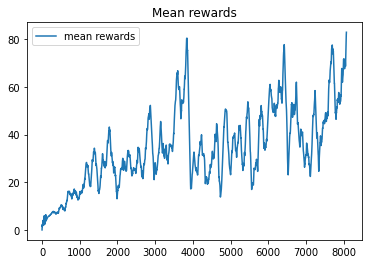

In [ ]:
plt.plot(rews, label='mean rewards')
plt.legend(loc='best')
plt.title("Mean rewards")
plt.show()